In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from py_cFBA import *

# Function to plot metabolite profiles
# Args:
# - metabolite: name of the metabolite to plot
# - color_met: color of the plot line
def plot_met(metabolite, color_met):
    for i, met in enumerate(imbalanced_mets):
        if met == metabolite:
            plt.plot(t, amounts[i, :], '.-', color=color_met, label=met)
            plt.legend()
            plt.xlabel('Time (h)')
            plt.ylabel('Metabolite levels (mol/mol$_{biomass}$)')

# Function to plot flux profiles
# Args:
# - flux: name of the flux (reaction) to plot
# - color_flx: color of the plot line
def plot_flux(flux, color_flx):
    for i, rxn in enumerate(rxns):
        if rxn == flux:
            plt.step(t[:-1], fluxes[i, :], '.--', color=color_flx, label=flux)
            plt.legend()
            plt.xlabel('Time (h)')
            plt.ylabel('Reaction rate (mol/mol$_{biomass}$/h)')

### First step: Generate an excel sheet backbone for the model
Requirenment: Stoichiometric matirx

In [2]:
# Read the S matrix from an Excel sheet
S_mat = pd.read_excel('Models S matrices.xlsx', sheet_name='Basic model', index_col=0, header=0)
imbalanced_mets = list(S_mat.index)  # List of imbalanced metabolites
rxns = list(S_mat.columns)  # List of reactions

# Uncomment the two lines of code below to generate the cFBA excel backbone from scratch
# Create model backbone for cFBA 
# (data, dt) = cFBA_backbone_from_S_matrix(S_mat)
# generate_cFBA_excel_sheet(S_mat, data, 'MinCell_01.xlsx')

# Since we are not generating this excel from scratch
dt = 0.5

# Indices imbalanced mets: 2, 3, 4
# Simulation time: 5
# Time gap: 0.5
# Capacities: yes
# Metabolites that are catalysts: 2

### Second setp: excel sheet
You need to manually complete the excel sheet information with:
- Imbalanced metabolites: mw for biomass components
- Lower and upper bound specifics
- A_cap values (in case of using capacities)

______________
### Third step: create SBML file

In [3]:
# Create SBML file for the model

excel_file = 'MinCell_01.xlsx'  # Input Excel file
output_file = 'MinCell SBMLA_01.xml'  # Output SBML file
excel_to_sbml(excel_file, output_file)  # Convert Excel to SBML


SBML document with metabolites information and catalysis annotations has been created and saved to MinCell SBMLA_01.xml.


### Fourth step: Perform optimization

In [17]:
# Load the SBML file and set up the cFBA model
sbml_file = "MinCell SBMLA_01.xml"  # SBML file for the model
quotas = []  # List of quotas (none in this case)
# Generate the Linear Programming (LP) model components for cFBA
cons, Mk, imbalanced_mets, nm, nr, nt = generate_LP_cFBA(sbml_file, quotas, dt)

# Test optimization with a specific alpha value
alpha_test = 1
prob = create_lp_problem(alpha_test, [*cons], Mk, imbalanced_mets)  # Create LP problem
status = prob.optimize()  # Optimize the problem
print('Test on model with no growth:', status)  # Print the optimization status

# Find the optimal alpha value
print('Time simulation:')
alpha, prob = find_alpha(cons, Mk, imbalanced_mets)
print('Growth of the system: {:.2f}'.format(alpha))  # Print the optimal alpha value

# Retrieve the solution (fluxes, amounts, and time points)
fluxes, amounts, t = get_fluxes_amounts(sbml_file, prob, dt)

Test on model with no growth: optimal
Time simulation:
0.02 min
Growth of the system: 1.80


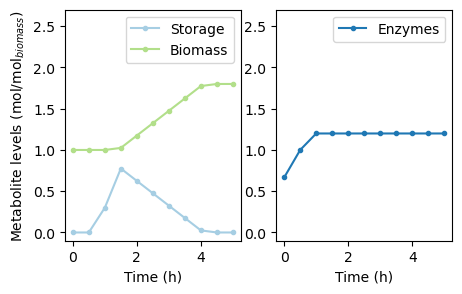

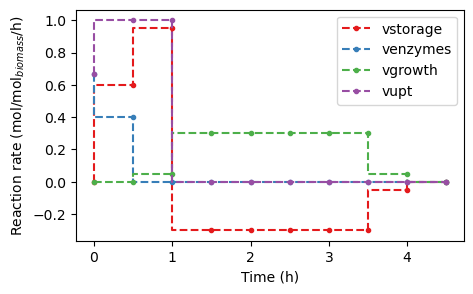

In [18]:
# Plot the metabolite changes over time
colors = ['#a6cee3', '#1f78b4', '#b2df8a']  # Colors for plotting

plt.figure(figsize=[5, 3])
plt.subplot(1, 2, 1)
plot_met('Storage', colors[0])  # Plot 'Storage' metabolite levels
plot_met('Biomass', colors[2])  # Plot 'Biomass' metabolite levels
plt.ylim([-0.1, 2.7])  # Set y-axis limits

plt.subplot(1, 2, 2)
plot_met('Enzymes', colors[1])  # Plot 'Enzymes' metabolite levels
plt.ylim([-0.1, 2.7])  # Set y-axis limits
plt.ylabel(None)  # Remove y-axis label

plt.savefig('MinCell_01_1.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()  # Show the plots

# Plot the flux changes over time
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # Colors for plotting

plt.figure(figsize=[5, 3])
plot_flux('vstorage', colors[0])  # Plot 'vstorage' flux
plot_flux('venzymes', colors[1])  # Plot 'venzymes' flux
plot_flux('vgrowth', colors[2])  # Plot 'vgrowth' flux
plot_flux('vupt', colors[3])  # Plot 'vupt' flux

plt.savefig('MinCell_01_2.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()  # Show the plots

### Now implementing some quotas

Test on model with no growth: optimal
Time simulation:
0.02 min
Growth of the system: 1.50


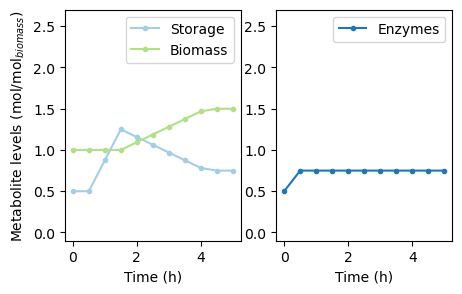

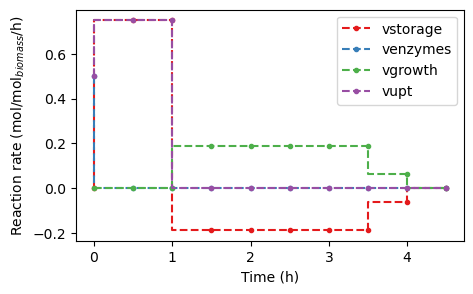

In [19]:
# Quotas for the model
quotas = [
#   ['type',     'metabolite', time, value]
    ['equality', 'Storage',    0,    0.5],
    ['max',      'Biomass',    2,    1],
    ['equality', 'Enzymes',    0,    0.5]
]

# SBML file for the model
sbml_file = "MinCell SBMLA_01.xml"

# Generate the LP model components for cFBA using the SBML file and quotas
cons, Mk, imbalanced_mets, nm, nr, nt = generate_LP_cFBA(sbml_file, quotas, dt)
print('Test on model with no growth:', status)  # Print the optimization status

# Find the optimal alpha value
print('Time simulation:')
alpha, prob = find_alpha(cons, Mk, imbalanced_mets)
print('Growth of the system: {:.2f}'.format(alpha))  # Print the optimal alpha value

# Retrieve the solution: fluxes, amounts, and time points
fluxes, amounts, t = get_fluxes_amounts(sbml_file, prob, dt)

# Plot the metabolite changes over time
colors = ['#a6cee3', '#1f78b4', '#b2df8a']  # Colors for plotting

plt.figure(figsize=[5, 3])
plt.subplot(1, 2, 1)
plot_met('Storage', colors[0])  # Plot 'Storage' metabolite levels
plot_met('Biomass', colors[2])  # Plot 'Biomass' metabolite levels
plt.ylim([-0.1, 2.7])  # Set y-axis limits

plt.subplot(1, 2, 2)
plot_met('Enzymes', colors[1])  # Plot 'Enzymes' metabolite levels
plt.ylim([-0.1, 2.7])  # Set y-axis limits
plt.ylabel(None)  # Remove y-axis label


plt.savefig('MinCell_01_3.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()  # Show the plots

# Plot the flux changes over time
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']  # Colors for plotting

plt.figure(figsize=[5, 3])
plot_flux('vstorage', colors[0])  # Plot 'vstorage' flux
plot_flux('venzymes', colors[1])  # Plot 'venzymes' flux
plot_flux('vgrowth', colors[2])  # Plot 'vgrowth' flux
plot_flux('vupt', colors[3])  # Plot 'vupt' flux


plt.savefig('MinCell_01_4.jpeg', bbox_inches = 'tight', dpi = 300)
plt.show()  # Show the plots
